In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import pandas as pd
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report

/kaggle/input/fake-news-detection-dataset-english/il_1140xN.1287758547_2nwc.png
/kaggle/input/fake-news-detection-dataset-english/True.csv/True.csv
/kaggle/input/fake-news-detection-dataset-english/Fake.csv/Fake.csv


First we have to load two seperate datasets corresponding to fake and true news.

In [3]:
fake_df = pd.read_csv("/kaggle/input/fake-news-detection-dataset-english/Fake.csv/Fake.csv")
true_df = pd.read_csv("/kaggle/input/fake-news-detection-dataset-english/True.csv/True.csv")

In [4]:
fake_df['false'] = 1
fake_df

,title,text,subject,date,false
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1
...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",1
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",1
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",1
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",1


In [7]:
true_df['false'] = 0
true_df

,title,text,subject,date,false
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",0
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",0
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",0
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",0


As we can see, we have ~23k fake news and ~21k true news. So our dataset is pretty much not imbalance. let's get started. 

In [8]:
df = pd.concat([true_df, fake_df])

Ok, I know EDA is a pretty good thing, but let's do it minimal this time with the focus on the objective which is classifying the news :)

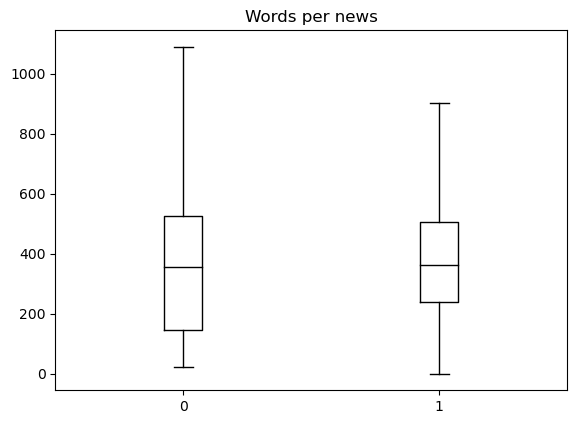

In [25]:
df["Words per news"] = df["text"].str.split().apply(len)
df.boxplot("Words per news", by="false", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

Now that we have the our dataset, let's bring the BERT LLM to create a nice embedding of the sentences.

Nothing fancy, downloading simplest BERT model from tf hub(eventually, I think, I had to download it from hugging face so sorry for the inconvenience)

In [9]:
preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")


Due to time and resource constraint, I only used half of data ~20K samples.

In [10]:

df = df.sample(20000)
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['false'],test_size = 0.3)


Simple NN arcitechture. with a 0.2 dropout layer and 16 hidden neurons with ReLU activation function and the output layer with Sigmoid.

Could have added batch norm and normalization layers but I try to keep things simple here.

In [12]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = preprocess(text_input)
outputs = encoder(preprocessed_text)

l = tf.keras.layers.Dense(16, activation='relu', name="hidden")(outputs['pooled_output'])
l = tf.keras.layers.Dropout(0.2, name="dropout")(l)
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [13]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [15]:
metrics = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='f1')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=metrics)

Let's fit the model for 10 epochs.

In [16]:
model.fit(X_train, y_train, epochs=10)


Epoch 1/10
438/438 [==============================] - 168s 355ms/step - loss: 0.3813 - accuracy: 0.8371 - precision: 0.8152 - f1: 0.8919
Epoch 2/10
438/438 [==============================] - 155s 354ms/step - loss: 0.2084 - accuracy: 0.9318 - precision: 0.9244 - f1: 0.9475
Epoch 3/10
438/438 [==============================] - 155s 354ms/step - loss: 0.1707 - accuracy: 0.9489 - precision: 0.9457 - f1: 0.9575
Epoch 4/10
438/438 [==============================] - 155s 354ms/step - loss: 0.1503 - accuracy: 0.9567 - precision: 0.9569 - f1: 0.9608
Epoch 5/10
438/438 [==============================] - 155s 354ms/step - loss: 0.1361 - accuracy: 0.9609 - precision: 0.9617 - f1: 0.9638
Epoch 6/10
438/438 [==============================] - 155s 354ms/step - loss: 0.1243 - accuracy: 0.9659 - precision: 0.9679 - f1: 0.9672
Epoch 7/10
438/438 [==============================] - 155s 353ms/step - loss: 0.1112 - accuracy: 0.9679 - precision: 0.9693 - f1: 0.9697
Epoch 8/10
438/438 [=====================

As we can see, model did a good job on test set Hooray!

In [17]:
model.evaluate(X_test, y_test)


188/188 [==============================] - 67s 352ms/step - loss: 0.0660 - accuracy: 0.9777 - precision: 0.9752 - f1: 0.9821


[0.06595751643180847,
 0.9776666760444641,
 0.9752459526062012,
 0.9821029305458069]

In [18]:
y_predicted = model.predict(X_test).flatten()
y_predicted = np.where(y_predicted > 0.5, 1, 0)


188/188 [==============================] - 66s 350ms/step


In [19]:
cm = confusion_matrix(y_test, y_predicted)
cm 

array([[2793,   78],
       [  56, 3073]])

Text(50.722222222222214, 0.5, 'True')

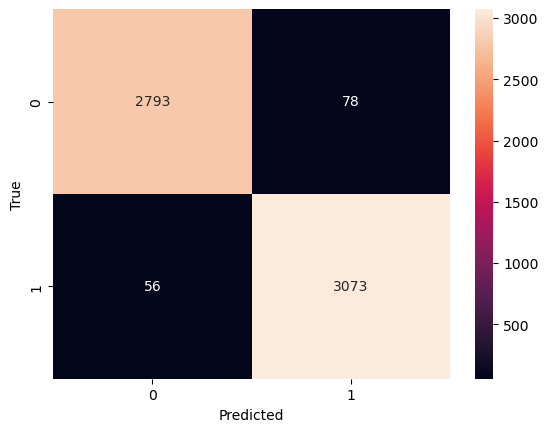

In [22]:
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')

In [53]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicted)

In [59]:
metrics.auc(fpr, tpr)

0.9774673371063095

AUC is 0.97, pretty good!

In [21]:
print(classification_report(y_test, y_predicted))


              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2871
           1       0.98      0.98      0.98      3129

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000



F1 score 0.98 it seems like a pretty good score!

Now let's randomly analyze some of the misclassified news.

In [45]:
lst = (y_test.values - y_predicted)
idxs_true = []
idxs_false = []
i = 0
for l in lst:
    if l == 1:
        idxs_false.append(i)
    elif l == -1:
        idxs_true.append(i)
    i += 1

78

In [49]:
X_test.iloc[idxs_true[3]]

'WARSAW (Reuters) - The president of the European Parliament said on Monday he would ask Poland s prime minister to ensure the security of Polish members of the assembly after a far-right protest staged a symbolic hanging of the politicians.  On Saturday a few dozen people in the southern Polish city of Katowice hanged the portraits of politicians who backed a  European Parliament resolution calling on the Polish government to condemn  the xenophobic and fascist march  held on Poland s Independence Day on Nov. 11.  I will write to PM Beata Szydlo to ensure the security of elected members of the European Parliament to express their opinions independently, without threat, and oppose those who spread hatred by exhibiting outrageous pictures of hanged politicians,  Antonio Tajani said on Twitter. Poland s socially conservative, euroskeptic government came under fire from the EU and human rights group for allowing far-right marchers - who were among some 60,000 people at the Nov. 11 rally -

In [52]:
X_test.iloc[idxs_false[1]]

'Former President Barack Obama seems to be feeling nostalgic for his old job, meeting with South Korean President Moon Jae-in Monday for 40 minutes.The Korea Herald reported that Moon spoke about his recent meetings with President Trump in Washington and asked Obama for his advice on how to improve that relationship.The meeting came after Obama spoke at the Asian Leadership Conference and the Fourth Congress of Indonesian Diaspora in Jakarta. There he attacked Trump s decision to withdraw from the Paris climate change accord. In Paris, we came together around the most ambitious agreement in history about climate change, an agreement that even with the temporary absence of American leadership can still give our children a fighting chance,  Obama said in Indonesia.The former president had said before leaving office that he appreciated his predecessor George W. Bush s silence during his tenure, but also contended that he s  still a citizen and that carries with it duties and obligations. 

Clearly this is fake news but the model labeled it as true news.

### How to improve the model:
1. Since we didn't use all of the data due to time and resource constraints, we can expect better result with more data.
2. Our NN arcitechture was so simple. Just a hidden layer and a dropout layer. Since we have 40k records it makes sense to create a more complex arcitechture by adding Initialization, Regularization terms, Normalization layers, Increasing Depth and node counts, testing other activation functions.
3. I used the simplest BERT model, maybe more complex BERT models would perform better.
4. Fine-tuning BERT on the dataset.